In [61]:
import os
from pathlib import Path
import logging
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.features.helpers import spacy_init, spacy_normalize, tfidf_init
from capstone.utils.constants import (
    TEXT,
    TARGET
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Genera...,[regulatory standards management]
1,General Quality System Requirements […] Manage...,"[quality planning, quality management]"
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)

dev, test = features.build(df)

2022-10-22 05:28:26,407 - capstone.features.features - INFO - Cleaning text
2022-10-22 05:28:26,484 - capstone.features.features - INFO - Applying language model
2022-10-22 05:29:12,760 - capstone.features.features - INFO - Applying lemmatization and removing stopwords
2022-10-22 05:29:13,092 - capstone.utils.utils - INFO - func:clean took: 46.69 sec
2022-10-22 05:29:13,839 - capstone.utils.utils - INFO - func:fit took: 47.43 sec
2022-10-22 05:29:13,841 - capstone.features.features - INFO - Cleaning text
2022-10-22 05:29:13,919 - capstone.features.features - INFO - Applying language model
2022-10-22 05:29:49,178 - capstone.features.features - INFO - Applying lemmatization and removing stopwords
2022-10-22 05:29:49,506 - capstone.utils.utils - INFO - func:clean took: 35.67 sec
2022-10-22 05:29:49,820 - capstone.utils.utils - INFO - func:transform took: 35.98 sec
2022-10-22 05:29:49,821 - capstone.utils.utils - INFO - func:fit_transform took: 1 min and 23.42 sec
2022-10-22 05:29:49,822 -

In [13]:
len(list(features.vectorizer.get_feature_names_out()))

562

<AxesSubplot:>

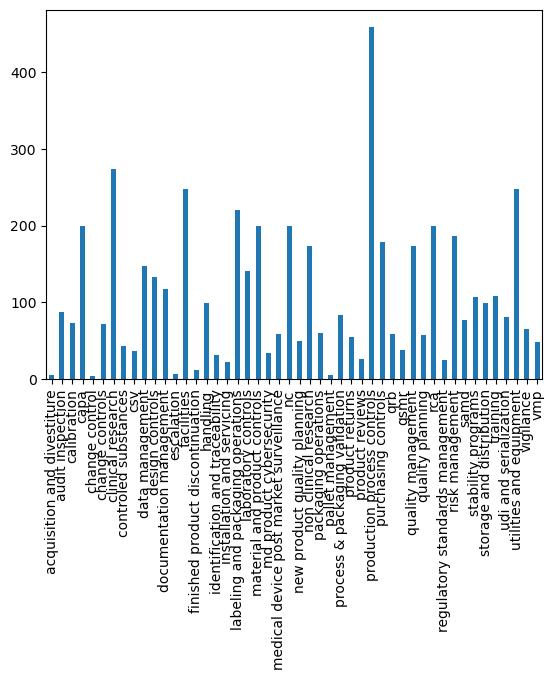

In [15]:
dev[features.mlb.classes_.tolist()].sum(axis=0).plot.bar()

<AxesSubplot:>

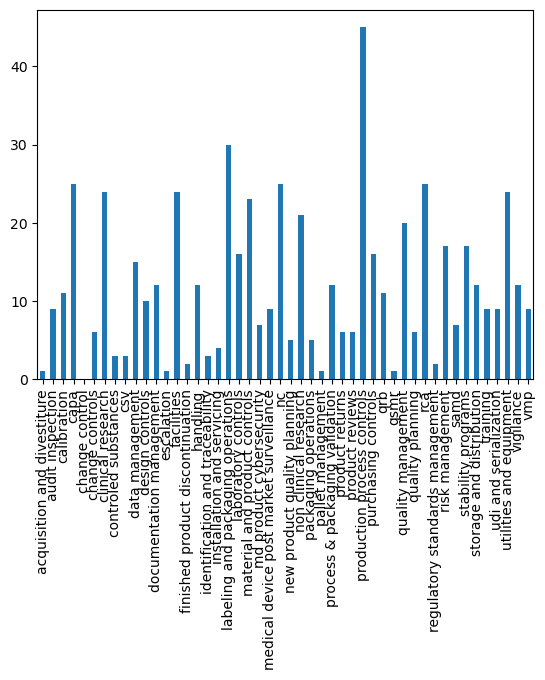

In [6]:
test[features.mlb.classes_.tolist()].sum(axis=0).plot.bar()

In [27]:
X_dev = dev[features.vectorizer.get_feature_names_out()].to_numpy()
Y_dev = dev[features.mlb.classes_.tolist()].to_numpy().astype(int)

X_test = test[features.vectorizer.get_feature_names_out()].to_numpy()
Y_test = test[features.mlb.classes_.tolist()].to_numpy().astype(int)

In [19]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

In [23]:
model = LinearSVC(class_weight="balanced", C=0.5, max_iter=2000)
models = MultiOutputClassifier(model)
models.fit(X_dev, Y_dev)

MultiOutputClassifier(estimator=LinearSVC(C=0.5, class_weight='balanced',
                                          max_iter=2000))

In [26]:
models.score(X_dev, Y_dev)

0.24751066856330015

In [28]:
models.score(X_test, Y_test)

0.1483375959079284

In [30]:
p = models.predict(X_test)

In [31]:
Y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [32]:
p[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [46]:
np.any(,)

array([[ True]])

In [49]:
np.equal(p, Y_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])

<AxesSubplot:>

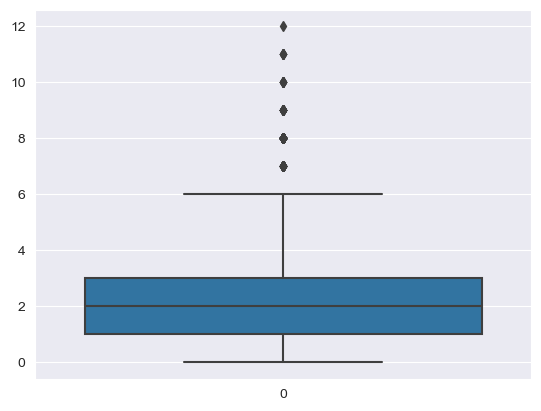

In [62]:
sns.boxplot((models.predict(X_dev) != Y_dev).sum(axis=1))

<AxesSubplot:>

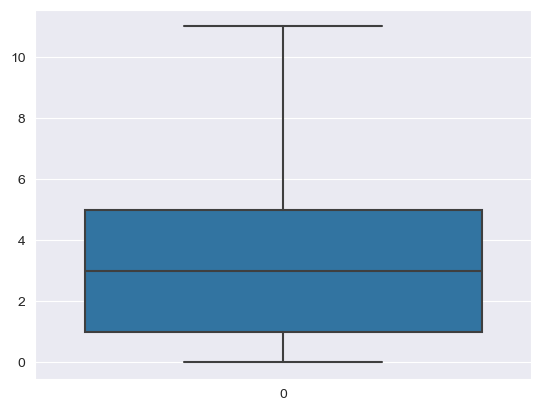

In [63]:
sns.boxplot((models.predict(X_test) != Y_test).sum(axis=1))

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest)
multi_target_forest.fit(X_dev, Y_dev)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1))

<AxesSubplot:>

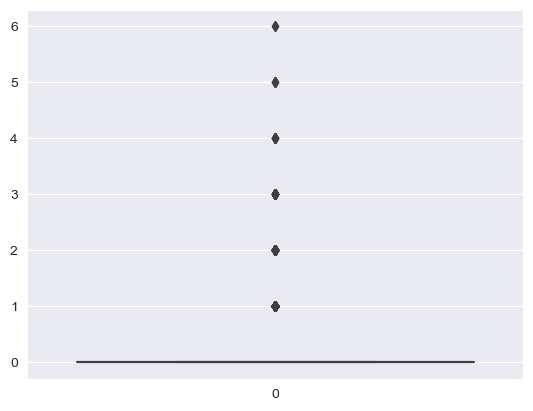

In [67]:
sns.boxplot((multi_target_forest.predict(X_dev) != Y_dev).sum(axis=1))

<AxesSubplot:>

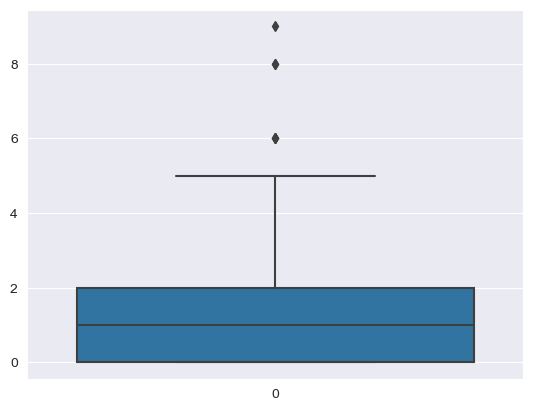

In [68]:
sns.boxplot((multi_target_forest.predict(X_test) != Y_test).sum(axis=1))